In [169]:
import re
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import isomorphism

In [154]:
class Node:
    def __init__(self, name=None, bitwidth=None, operation=None, operands=None, 
                 idNum=None, value=None, pos=None, FuncIO=None, start=None, width=None):
        self.name = name
        self.bitwidth = bitwidth
        self.operation = operation
        self.operands = operands
        self.idNum = idNum
        self.value = value
        self.pos = pos
        self.FuncIO = FuncIO
        self.start = start
        self.width = width

    def __repr__(self):
        return f"Node(name={self.name}, bitwidth={self.bitwidth}, operation={self.operation}, operands={self.operands}, id={self.idNum}, value={self.value}, pos={self.pos}, FuncIO={self.FuncIO}, start={self.start}, width={self.width})"

def node_to_dict(node):
    return {
        "name": node.name,
        "bitwidth": node.bitwidth,
        "operation": node.operation,
        "operands": node.operands,
        "idNum": node.idNum,
        "value": node.value,
        "pos": node.pos,
        "FuncIO": node.FuncIO,
        "Start": node.start,
        "width": node.width
    }
    
def ParseIRFile(ir_text):
    nodes_dict = {}
    lines = ir_text.strip().split("\n")[4:] 
    return lines

def LineToDict(line):
    nodes = []
    # Check for function header
    FuncIO = "Not"
    if "fn" in line:
        FuncIO = "In"
        # Extract everything between ( and )
        args_str = re.search(r'\((.*?)\)', line).group(1)
        # Split by comma to get individual arguments
        args = args_str.split(',')
        for arg in args:
            # Extract name and bitwidth
            name, bit_info = [s.strip() for s in arg.split(':')]
            bitwidth = int(re.search(r'bits\[(\d+)\]', bit_info).group(1))
            # Create a Node object for each argument
            node = Node(name=name, bitwidth=bitwidth, FuncIO=FuncIO)
            nodes.append(node)
        return nodes
    if "ret" in line:
        FuncIO = "Out"
        line = line[4:]
        
    if line == "}":
        return None

    # Extract node name
    name = re.search(r"(\w+\.\d+):", line).group(1)

    # Extract bitwidth
    bitwidth = int(re.search(r"bits\[(\d+)\]", line).group(1))

    # Extract operation
    operation = re.search(r"= (\w+)", line).group(1)

    # Extract operands; filter out the operation, "value", "id", and "pos"
    operands = re.findall(r"(\w+\.\d+|\w+)", line.split("=")[1])
    operands = [op for op in operands if op not in [operation, "value", "id", "pos", "start", "width"]]


    # Extract id
    idNum = int(re.search(r"id=(\d+)", line).group(1))

    # Extract value (if present)
    value_match = re.search(r"value=(\d+)", line)
    value = int(value_match.group(1)) if value_match else None

    # Extract pos (if present)
    pos_match = re.search(r"pos=\[\((\d+,\d+,\d+)\)\]", line)
    pos = tuple(map(int, pos_match.group(1).split(","))) if pos_match else None

    # Extract start and width for bit_slice (if present)
    start = None
    width = None
    if operation == "bit_slice":
        start = int(re.search(r"start=(\d+)", line).group(1))
        width = int(re.search(r"width=(\d+)", line).group(1))

    # Create Node object
    node = Node(name, bitwidth, operation, operands, idNum, value, pos, FuncIO, start, width)
    
    # Add to node list
    nodes.append(node)
    return nodes

def DictToGraph(G, NodeDict):
    # This function turns the node dictionary to directional graph
    NodeList = []
    EdgeList = []
    for NodeName in NodeDict:
        if NodeDict[NodeName].FuncIO != "In": 
            # This if is for handling the function top input, they are treated as nodes as well.
            NodeList.append((NodeDict[NodeName].idNum, node_to_dict(NodeDict[NodeName])))
            for ParentName in NodeDict[NodeName].operands:
                if NodeDict[ParentName].FuncIO != "In":
                    EdgeList.append((NodeDict[ParentName].idNum, NodeDict[NodeName].idNum))
                else: 
                    EdgeList.append((NodeDict[ParentName].name, NodeDict[NodeName].idNum))
        else:
            NodeList.append((NodeDict[NodeName].name, node_to_dict(NodeDict[NodeName])))

    G.add_nodes_from(NodeList)
    G.add_edges_from(EdgeList)
    return G
    

In [213]:
# Define the file path
file_path = "/home/miao/xls/work_space/my_test.opt.ir"
file_path = "/home/miao/xls/work_space/test.opt.ir"
# file_path = "/home/miao/xls/work_space/UNROLL.opt.ir"

# Open the file and read its contents
with open(file_path, 'r') as f:
    ir_content = f.read()

print(ir_content)
# Now you can print or process the `ir_content`



package my_package

file_number 1 "././work_space/test.cc"

top fn test_unroll(x: bits[32], y: bits[32], z: bits[32]) -> bits[32] {
  add.22: bits[32] = add(x, y, id=22, pos=[(1,8,3)])
  ret mul.23: bits[32] = mul(z, add.22, id=23, pos=[(1,8,3)])
}



In [214]:

NodeDict = {}
Lines = ParseIRFile(ir_content)

for Line in Lines:
    NodeList = LineToDict(Line)
    if NodeList != None:
        for NodeObj in NodeList:
            NodeDict[NodeObj.name] = NodeObj
            print(NodeDict[NodeObj.name])

    

Node(name=x, bitwidth=32, operation=None, operands=None, id=None, value=None, pos=None, FuncIO=In, start=None, width=None)
Node(name=y, bitwidth=32, operation=None, operands=None, id=None, value=None, pos=None, FuncIO=In, start=None, width=None)
Node(name=z, bitwidth=32, operation=None, operands=None, id=None, value=None, pos=None, FuncIO=In, start=None, width=None)
Node(name=add.22, bitwidth=32, operation=add, operands=['x', 'y'], id=22, value=None, pos=(1, 8, 3), FuncIO=Not, start=None, width=None)
Node(name=mul.23, bitwidth=32, operation=mul, operands=['z', 'add.22'], id=23, value=None, pos=(1, 8, 3), FuncIO=Out, start=None, width=None)


NodeView(('x', 'y', 'z', 22, 23))

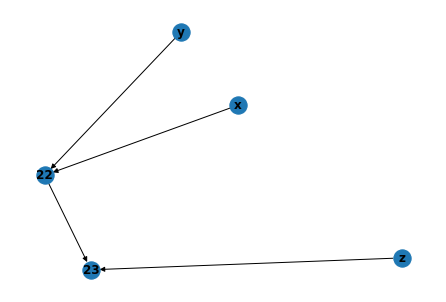

In [215]:
G = nx.DiGraph()
G = DictToGraph(G, NodeDict)
nx.draw(G, with_labels=True, font_weight='bold')
G.nodes

In [202]:
class CustomMatcher(isomorphism.DiGraphMatcher):
    def semantic_feasibility(self, n1, n2):
        # Ensure operations match
        if self.G1.nodes[n1].get('operation') != self.G2.nodes[n2].get('operation'):
            return False

        # Ensure 'add' nodes in the main graph G1 have only one outgoing edge
        if self.G1.nodes[n1].get('operation') == 'add' and self.G1.out_degree(n1) > 1:
            return False

        return True




{22: 'add', 23: 'mul'}


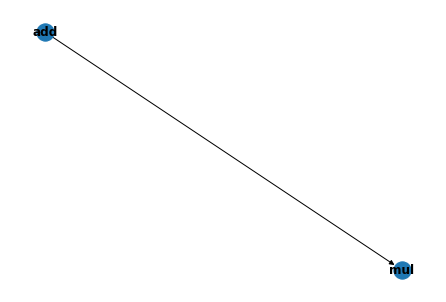

In [219]:
P = nx.DiGraph()


P.add_node('add', operation='add')
P.add_node('mul', operation='mul')
# P.add_node('a', operation=None)  
# P.add_node('b', operation=None) 
# P.add_node('c', operation=None)  


# P.add_edge('a', 'add')
# P.add_edge('b', 'add')
P.add_edge('add', 'mul')
# P.add_edge('c', 'mul')


GM = CustomMatcher(G, P, node_match=lambda n1, n2: n1.get('operation') == n2.get('operation'))
nx.draw(P, with_labels=True, font_weight='bold')

for subgraph in GM.subgraph_isomorphisms_iter():
    print(subgraph)  # This will print node mappings from G to P